# Introduction to Theano

Credits: Forked from [summerschool2015](https://github.com/mila-udem/summerschool2015) by mila-udem

## Slides

Refer to the associated [Introduction to Theano slides](http://nbviewer.ipython.org/github/donnemartin/data-science-ipython-notebooks/blob/master/deep-learning/theano-tutorial/intro_theano/intro_theano.pdf) and use this notebook for hands-on practice of the concepts.

## Basic usage

### Defining an expression

In [1]:
import theano
from theano import tensor as T
x = T.vector('x')
W = T.matrix('W')
b = T.vector('b')

In [2]:
dot = T.dot(x, W)
out = T.nnet.sigmoid(dot + b)

### Graph visualization

In [3]:
from theano.printing import debugprint
debugprint(dot)

dot [@A] ''   
 |x [@B]
 |W [@C]


In [4]:
debugprint(out)

sigmoid [@A] ''   
 |Elemwise{add,no_inplace} [@B] ''   
   |dot [@C] ''   
   | |x [@D]
   | |W [@E]
   |b [@F]


### Compiling a Theano function

In [5]:
f = theano.function(inputs=[x, W], outputs=dot)
g = theano.function([x, W, b], out)
h = theano.function([x, W, b], [dot, out])
i = theano.function([x, W, b], [dot + b, out])

### Graph visualization

In [6]:
debugprint(f)

CGemv{inplace} [@A] ''   3
 |AllocEmpty{dtype='float64'} [@B] ''   2
 | |Shape_i{1} [@C] ''   1
 |   |W [@D]
 |TensorConstant{1.0} [@E]
 |InplaceDimShuffle{1,0} [@F] 'W.T'   0
 | |W [@D]
 |x [@G]
 |TensorConstant{0.0} [@H]


In [7]:
debugprint(g)

Elemwise{ScalarSigmoid}[(0, 0)] [@A] ''   2
 |CGemv{no_inplace} [@B] ''   1
   |b [@C]
   |TensorConstant{1.0} [@D]
   |InplaceDimShuffle{1,0} [@E] 'W.T'   0
   | |W [@F]
   |x [@G]
   |TensorConstant{1.0} [@D]


In [8]:
from theano.printing import pydotprint
pydotprint(f, outfile='pydotprint_f.png')

The output file is available at pydotprint_f.png


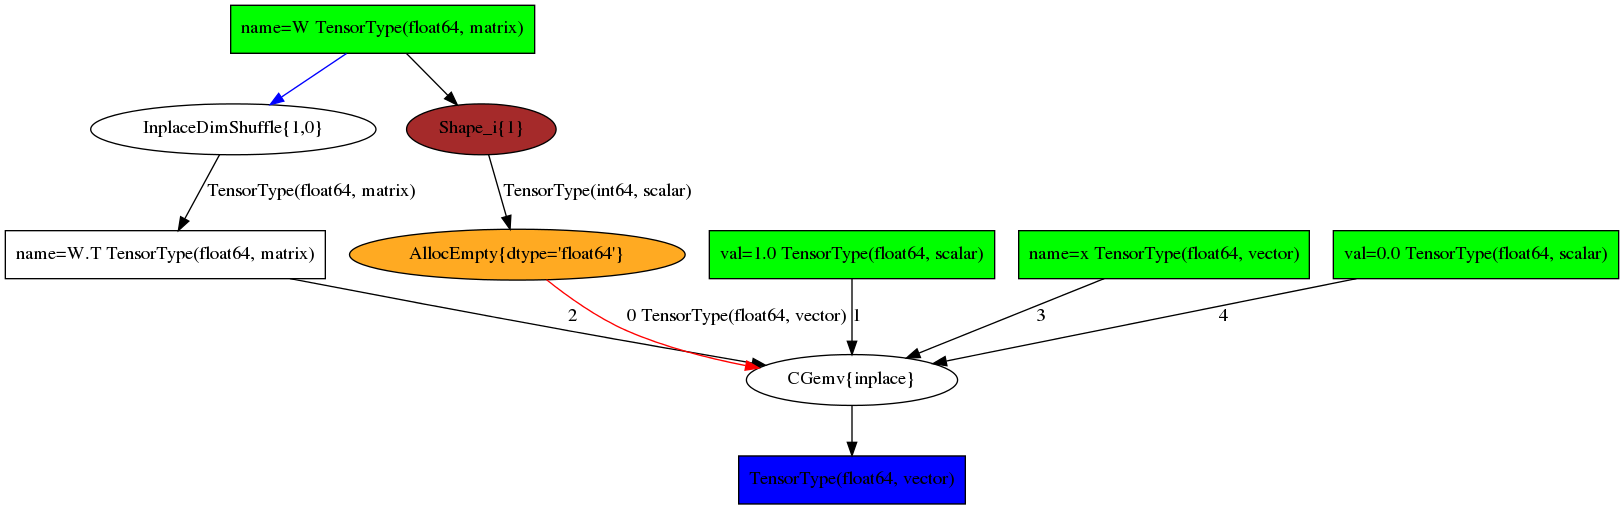

In [9]:
from IPython.display import Image
Image('pydotprint_f.png', width=1000)

The output file is available at pydotprint_g.png


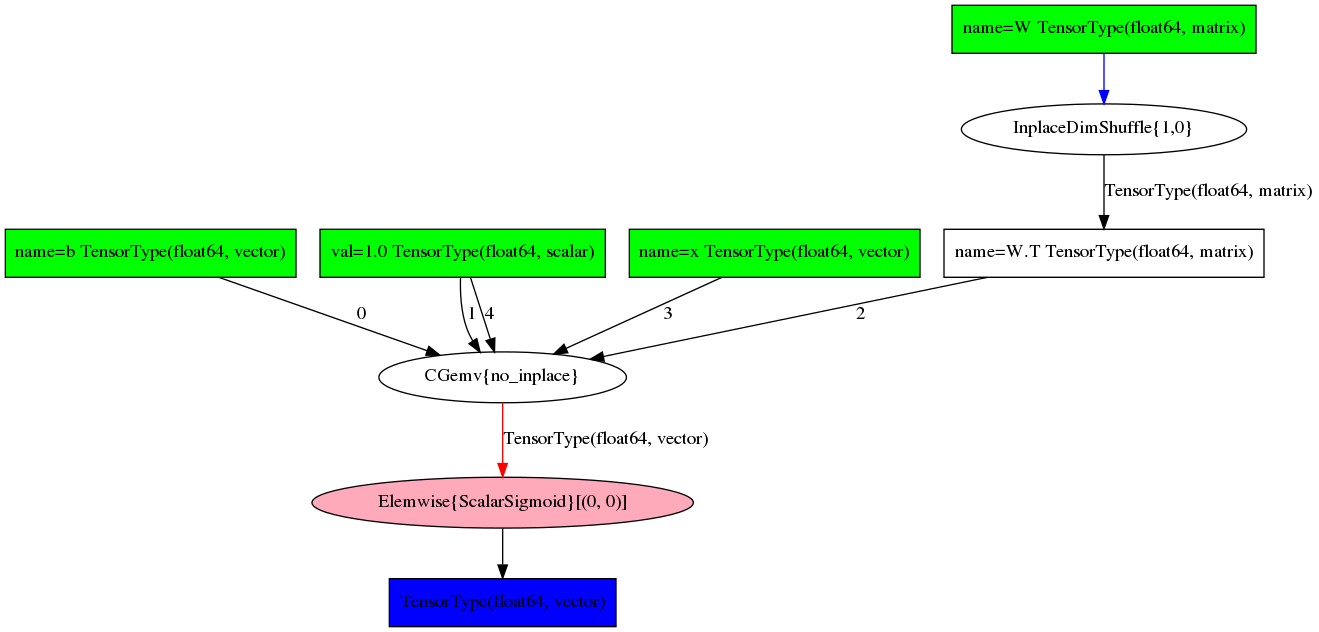

In [10]:
pydotprint(g, outfile='pydotprint_g.png')
Image('pydotprint_g.png', width=1000)

The output file is available at pydotprint_h.png


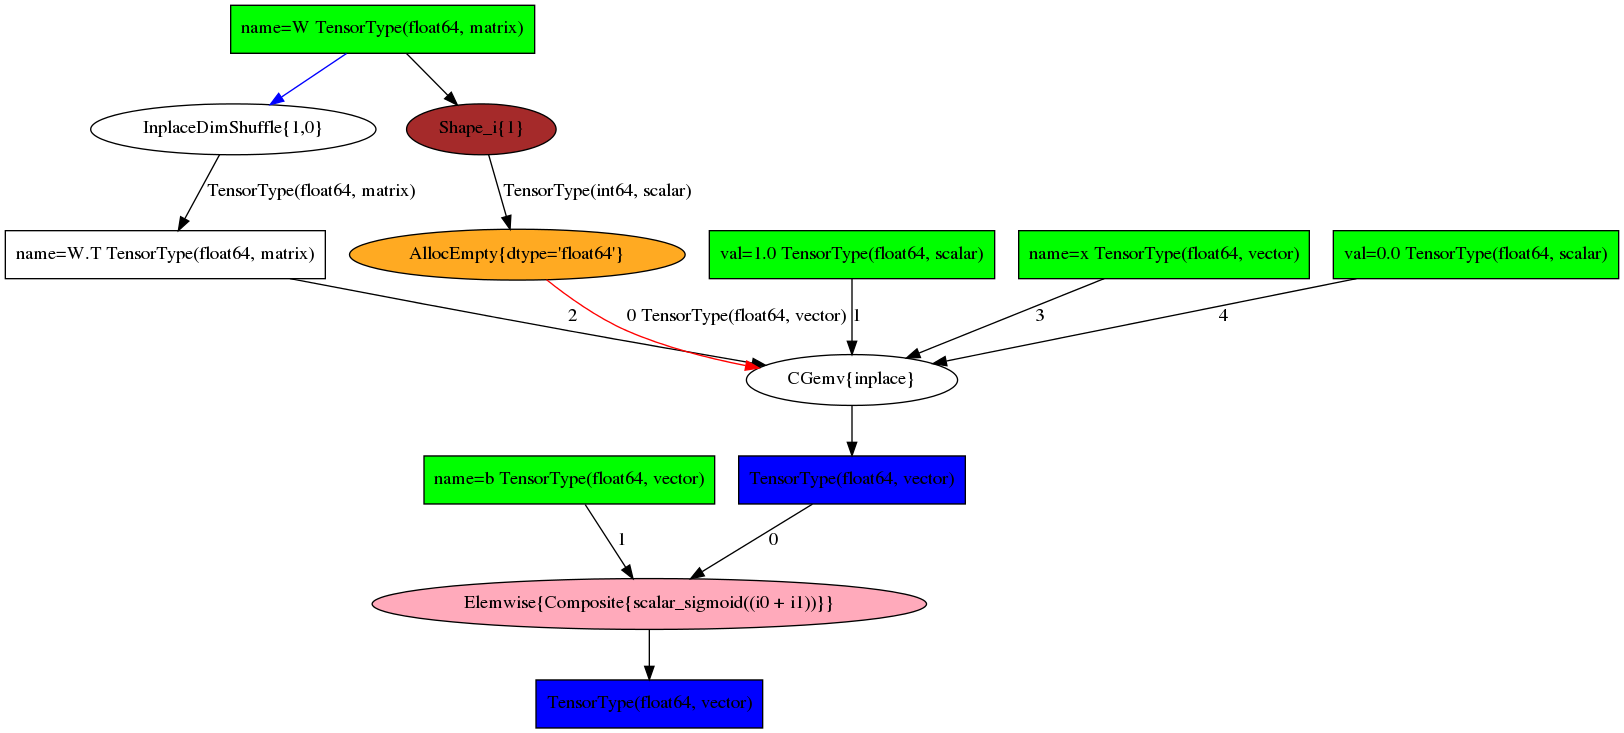

In [11]:
pydotprint(h, outfile='pydotprint_h.png')
Image('pydotprint_h.png', width=1000)

### Executing a Theano function

In [12]:
import numpy as np
np.random.seed(42)
W_val = np.random.randn(4, 3)
x_val = np.random.rand(4)
b_val = np.ones(3)

f(x_val, W_val)

array([ 1.79048354,  0.03158954, -0.26423186])

In [13]:
g(x_val, W_val, b_val)

array([ 0.9421594 ,  0.73722395,  0.67606977])

In [14]:
h(x_val, W_val, b_val)

[array([ 1.79048354,  0.03158954, -0.26423186]),
 array([ 0.9421594 ,  0.73722395,  0.67606977])]

In [15]:
i(x_val, W_val, b_val)

[array([ 2.79048354,  1.03158954,  0.73576814]),
 array([ 0.9421594 ,  0.73722395,  0.67606977])]

# Graph definition and Syntax
## Graph structure

The output file is available at pydotprint_f_notcompact.png


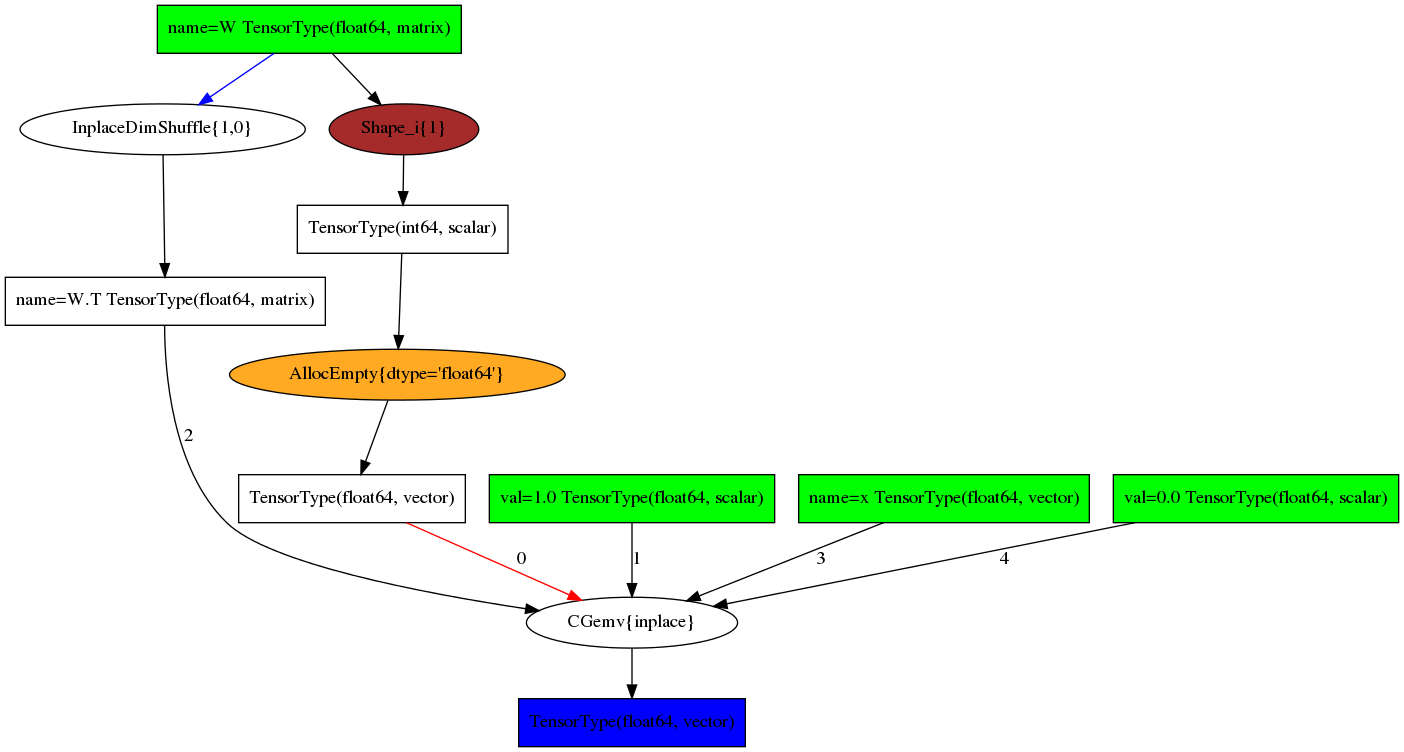

In [16]:
pydotprint(f, compact=False, outfile='pydotprint_f_notcompact.png')
Image('pydotprint_f_notcompact.png', width=1000)

## Strong typing
### Broadcasting tensors

In [17]:
r = T.row('r')
print(r.broadcastable)

(True, False)


In [18]:
c = T.col('c')
print(c.broadcastable)

(False, True)


In [19]:
f = theano.function([r, c], r + c)
print(f([[1, 2, 3]], [[.1], [.2]]))

[[ 1.1  2.1  3.1]
 [ 1.2  2.2  3.2]]


# Graph Transformations
## Substitution and Cloning
### The `givens` keyword

In [20]:
x_ = T.vector('x_')
x_n = (x_ - x_.mean()) / x_.std()
f_n = theano.function([x_, W], dot, givens={x: x_n})
f_n(x_val, W_val)

array([ 1.90651511,  0.60431744, -0.64253361])

### Cloning with replacement

In [21]:
dot_n, out_n = theano.clone([dot, out], replace={x: (x - x.mean()) / x.std()})                        
f_n = theano.function([x, W], dot_n)                                                                  
f_n(x_val, W_val)

array([ 1.90651511,  0.60431744, -0.64253361])

## Gradient
### Using `theano.grad`

In [22]:
y = T.vector('y')
C = ((out - y) ** 2).sum()
dC_dW = theano.grad(C, W)
dC_db = theano.grad(C, b)
# dC_dW, dC_db = theano.grad(C, [W, b])

### Using the gradients

In [23]:
cost_and_grads = theano.function([x, W, b, y], [C, dC_dW, dC_db])
y_val = np.random.uniform(size=3)
print(cost_and_grads(x_val, W_val, b_val, y_val))

[array(0.6137821438190066), array([[ 0.01095277,  0.07045955,  0.051161  ],
       [ 0.01889131,  0.12152849,  0.0882424 ],
       [ 0.01555008,  0.10003427,  0.07263534],
       [ 0.01048429,  0.06744584,  0.04897273]]), array([ 0.03600015,  0.23159028,  0.16815877])]


In [24]:
upd_W = W - 0.1 * dC_dW
upd_b = b - 0.1 * dC_db
cost_and_upd = theano.function([x, W, b, y], [C, upd_W, upd_b])
print(cost_and_upd(x_val, W_val, b_val, y_val))

[array(0.6137821438190066), array([[ 0.49561888, -0.14531026,  0.64257244],
       [ 1.52114073, -0.24630622, -0.2429612 ],
       [ 1.57765781,  0.7574313 , -0.47673792],
       [ 0.54151161, -0.47016228, -0.47062703]]), array([ 0.99639999,  0.97684097,  0.98318412])]


The output file is available at pydotprint_cost_and_upd.png


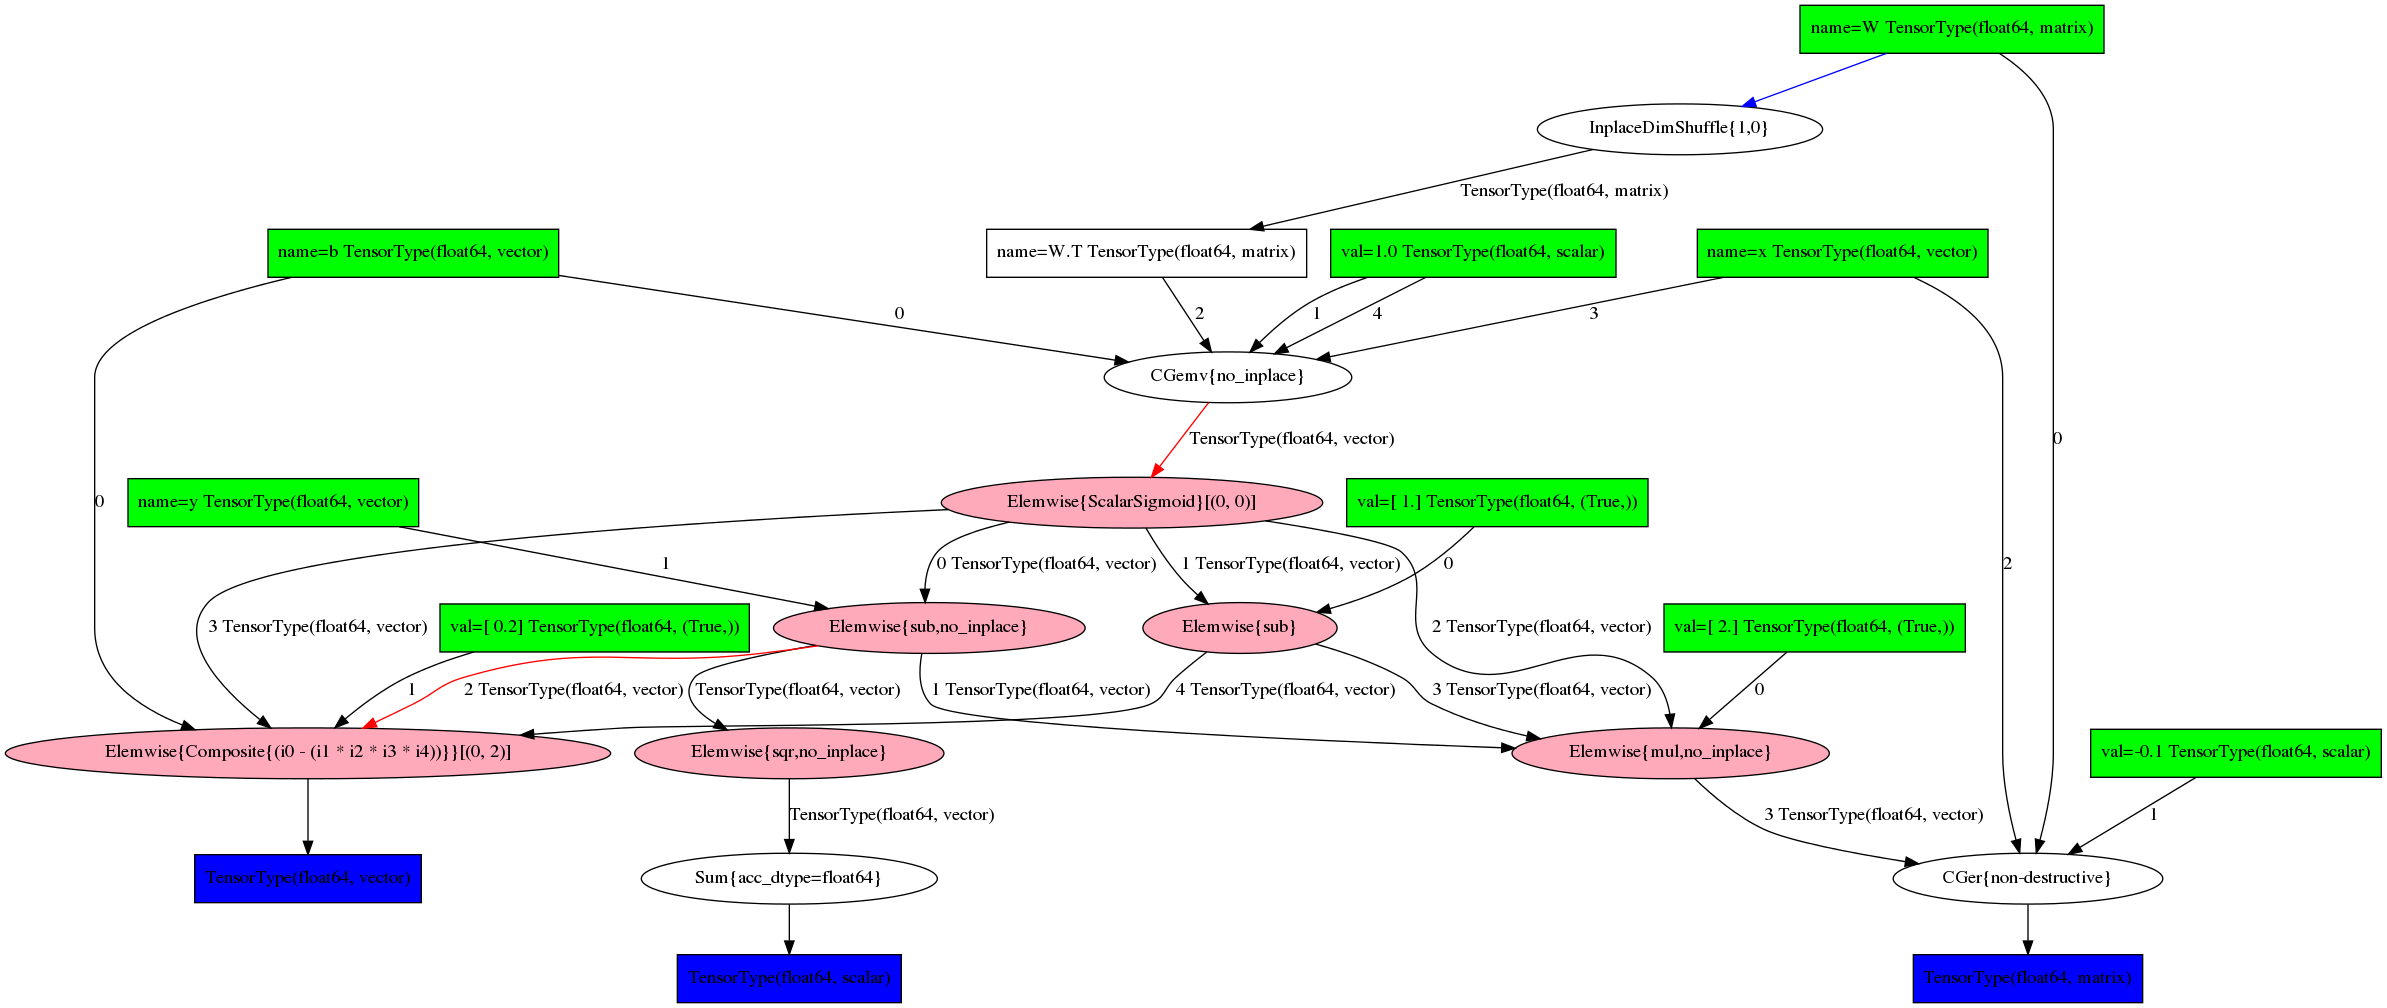

In [25]:
pydotprint(cost_and_upd, outfile='pydotprint_cost_and_upd.png')
Image('pydotprint_cost_and_upd.png', width=1000)

## Shared variables
### Update values

In [26]:
C_val, dC_dW_val, dC_db_val = cost_and_grads(x_val, W_val, b_val, y_val)
W_val -= 0.1 * dC_dW_val
b_val -= 0.1 * dC_db_val

C_val, W_val, b_val = cost_and_upd(x_val, W_val, b_val, y_val)

### Using shared variables

In [27]:
x = T.vector('x')
y = T.vector('y')
W = theano.shared(W_val)
b = theano.shared(b_val)
dot = T.dot(x, W)
out = T.nnet.sigmoid(dot + b)
f = theano.function([x], dot)  # W is an implicit input
g = theano.function([x], out)  # W and b are implicit inputs
print(f(x_val))

[ 1.78587062  0.00189954 -0.28566499]


In [28]:
print(g(x_val))

[ 0.94151144  0.72221187  0.66391952]


### Updating shared variables

In [29]:
C = ((out - y) ** 2).sum()
dC_dW, dC_db = theano.grad(C, [W, b])
upd_W = W - 0.1 * dC_dW
upd_b = b - 0.1 * dC_db

cost_and_perform_updates = theano.function(
    inputs=[x, y],
    outputs=C,
    updates=[(W, upd_W),
             (b, upd_b)])

The output file is available at pydotprint_cost_and_perform_updates.png


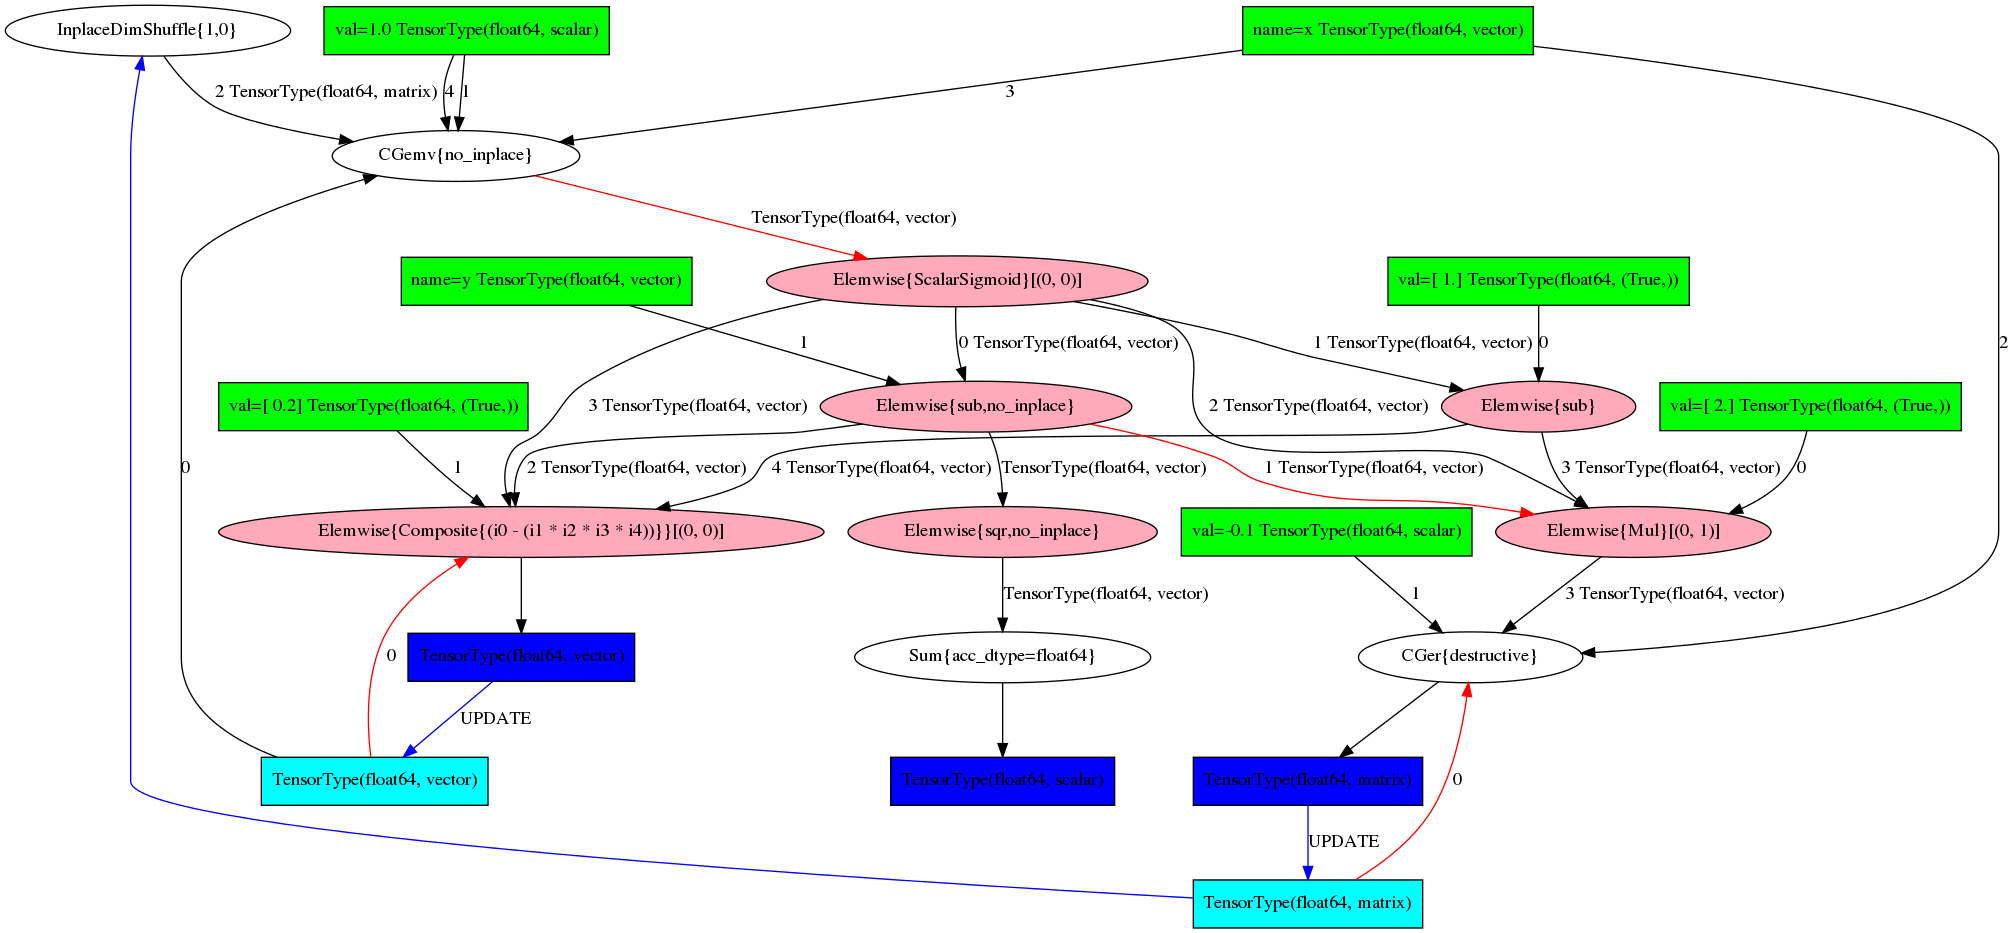

In [30]:
pydotprint(cost_and_perform_updates, outfile='pydotprint_cost_and_perform_updates.png')
Image('pydotprint_cost_and_perform_updates.png', width=1000)

# Advanced Topics
## Extending Theano
### The easy way: Python

In [31]:
import theano
import numpy
from theano.compile.ops import as_op

def infer_shape_numpy_dot(node, input_shapes):
    ashp, bshp = input_shapes
    return [ashp[:-1] + bshp[-1:]]

@as_op(itypes=[theano.tensor.fmatrix, theano.tensor.fmatrix],
       otypes=[theano.tensor.fmatrix], infer_shape=infer_shape_numpy_dot)
def numpy_dot(a, b):
   return numpy.dot(a, b)